# 뉴스 요약봇 만들기

텍스트 요약을 구현하는 Extractive/Abstractive 접근법에 대해 알아보고, Attentional seq2seq 구조를 활용하여 뉴스 기사를 모델을 구현해 본다.


- 들어가며
- 텍스트 요약(Text Summarization)이란?
- 인공 신경망으로 텍스트 요약 훈련시키기
- 데이터 준비하기
- 데이터 전처리하기
  - 데이터 정리하기
  - 훈련데이터와 테스트데이터 나누기
  - 정수 인코딩
- 모델 설계하기
- 모델 훈련하기
- 인퍼런스 모델 구현하기
- 모델 테스트하기
- 추출적 요약 해보기
- 프로젝트: 뉴스기사 요약해보기
- 프로젝트 제출

## 들어가기

텍스트 요약(Text Summarization)기술

- Extractive/Abstractive summarization 이해하기
- 단어장 크기를 줄이는 다양한 text normalization 적용해보기
- seq2seq의 성능을 Up시키는 Attention Mechanism 적용하기

## 텍스트 요약(Text Summarization)이란?

![00](img/00.png)

긴 길이의 문서(Document) 원문을 핵심 주제만으로 구성된 짧은 요약(Summary) 문장들로 변환하는 것

정보 손실 발생이 최소화되어야 한다는 점

접근법
  - 추출적 요약(Extractive Summarization)
  - 추상적 요약(Abstractive Summarization)

추출적 요약(Extractive Summarization)
***
원문에서 문장들을 추출해서 요약하는 방식

전통적인 머신 러닝 방식에 속하는 텍스트 랭크(TextRank)와 같은 알고리즘을 사용해서 이 방법

[네이버 뉴스 - 요약봇](https://news.naver.com/)

추상적 요약(Abstractive Summarization)
***
원문으로부터 내용이 요약된 새로운 문장을 생성해내는 것

자연어 생성(Natural Language Generation, NLG)의 영역인 셈

요약문에 들어갈 핵심문장인지를 판별한다는 점에서 문장 분류(Text Classification) 문제로 볼 수 있을 것

구글은 뉴스 기사 내용으로부터 자동으로 뉴스 제목을 뽑아내는 텍스트 요약 모델을 구현

[구글 인공지능 "뉴스 제목도 잘 뽑네"](https://zdnet.co.kr/view/?no=20160905114833&from=Mobile)

## 인공 신경망으로 텍스트 요약 훈련시키기

![Abstractive text summary with Reinforcement Learning](img/01.png)

[Abstractive text summary with Reinforcement Learning](https://medium.com/dl-for-product-and-service/abstractive-text-summary-with-reinforcement-learning-ab2458ab29d5)

다음 모델을 사용할 예정

![RNN vs LSTM](img/02.png)

LSTM을 사용함

![시작 토큰 SOS와 종료 토큰 EOS는 각각 start of a sequence와 end of a sequence를 나타낸다](img/03.png)

[시작 토큰 SOS와 종료 토큰 EOS는 각각 start of a sequence와 end of a sequence를 나타낸다](https://arxiv.org/pdf/1812.02303.pdf)

![04](img/04.png)

인코더의 마지막 time step의 hidden state를 컨텍스트 벡터로 사용

어텐션 메커니즘(Attention Mechanism) 은 이와 달리, 인코더의 모든 step의 hidden state의 정보가 컨텍스트 벡터에 전부 반영

hidden state의 가중치 값은 디코더의 현재 스텝이 어디냐에 따라 계속 달라진다는 점

- seq2seq를 사용합니다.
- RNN 계열 중 LSTM을 사용하므로 hidden state뿐만 아니라 cell state도 사용해야 합니다.
- 디코더의 예측 시퀀스에는 시작 토큰 SOS와 예측 토큰 EOS를 시퀀스의 앞, 뒤로 붙입니다.
- seq2seq를 구동시키면 디코더는 시작 토큰을 입력받아 예측을 시작합니다.
- seq2seq 기본 모델과 달리, 어텐션 메커니즘을 이용해 인코더의 hidden state의 중요도를 취합한 컨텍스트 벡터를 디코더 스텝별로 계산합니다.
- 계산된 컨텍스트 벡터를 이용해서 디코더는 다음 등장할 단어를 예측합니다.

## 데이터 준비하기

In [2]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print('=3')

[nltk_data] Downloading package stopwords to /Users/main/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


=3


In [3]:
data = pd.read_csv("data/Reviews.csv", nrows=100000)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 100000


In [4]:
data = data[['Text','Summary']]
data.head()

#랜덤한 15개 샘플 출력
data.sample(15)

,Text,Summary
59341,"They taste amazing, have great texture, and ar...","We are not health foodies, but we LOVE these"
68652,This was actually a little nasty. I love beef...,Yuck. Wish I would have spent a little more $...
782,Really easy project for family fun anytime not...,"My sons 9 & 11 loved making this, as easy enou..."
81243,These are great mushrooms and you can't find t...,Great mushrooms
57471,"Don't be fooled by the image for this item, wh...",Very tiny amount excessively priced!
23740,These chips are excellent! They stopped carryi...,"Great product, too bad I wasn't sent the corre..."
87434,Purchased these noodles when our family was pu...,Such a waste of money
67938,"We've long enjoyed this brand of chip, so when...","CRISPY, CRUNCHY, AND ROBUST"
6213,"This is a hefty roll of mylar! The 50"" width a...",heavy duty!
85503,Upon receiving this product after my son had c...,Do not purchase this product!


## 데이터 전처리하기

### 데이터 정리하기

In [5]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['Summary'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 88426
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 72348


In [6]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['Text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88426


In [7]:
print(data.isnull().sum())

Text       0
Summary    1
dtype: int64


In [8]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88425


[텍스트 정규화(text normalization) 필요](https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python)

In [9]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [10]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [13]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('=3')

=3


In [14]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("summary:", preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
summary: great way to start the day


In [15]:
clean_text = []
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['Text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better', 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo', 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch', 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal', 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']


In [16]:
clean_summary = []
# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['Summary']:
    clean_summary.append(preprocess_sentence(s, False))

print("Summary 전처리 후 결과: ", clean_summary[:5])

Summary 전처리 후 결과:  ['good quality dog food', 'not as advertised', 'delight says it all', 'cough medicine', 'great taffy']


In [17]:
data['Text'] = clean_text
data['Summary'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
print('=3')

=3


In [18]:
data.isnull().sum()

Text        0
Summary    70
dtype: int64

In [19]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88355


### 훈련데이터와 테스트데이터 나누기

텍스트의 최소 길이 : 2
텍스트의 최대 길이 : 1235
텍스트의 평균 길이 : 38.792428272310566
요약의 최소 길이 : 1
요약의 최대 길이 : 28
요약의 평균 길이 : 4.010729443721352


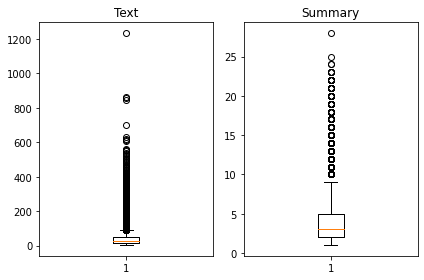

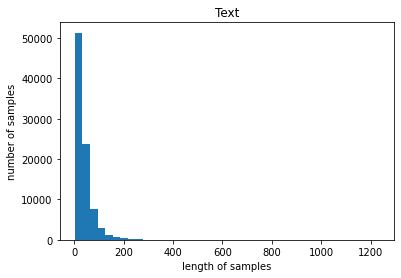

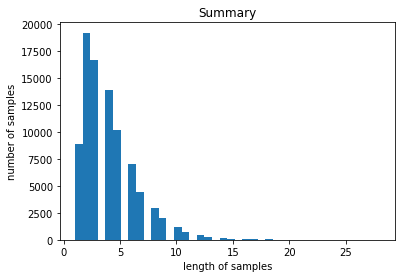

In [20]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

### 정수 인코딩

## 모델 설계하기

## 모델 훈련하기

## 인퍼런스 모델 구현하기

## 모델 테스트하기

## 추출적 요약 해보기

## 프로젝트: 뉴스기사 요약해보기

## 프로젝트 제출